# Face Mask Detection

The goal of this project is to use CNN to determine whether or not a person is wearing a mask. In this project, we achieved a 92.02% accuracy in the training set and a 96% accuracy in the validation set.

Link to data set -> https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

### Improting required libraries

1. We are using tensorflow keras to build the model
2. We are using pandas to create the dataset
3. seaborn and matplotlib are used to visualize the data

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import sklearn
import seaborn as sns
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D, MaxPool2D, Activation, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt

In [2]:
#import tensorflow
physical_devices = tensorflow.config.list_physical_devices("GPU")
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

### Declaring the paths to the images

1. mask_path is the path for images of people wearing masks
2. nomask_path is the path for imagees of people who are not wearing masks

In [4]:
mask_path = "./Face Mask Dataset/data/WithMask/"
nomask_path = "./Face Mask Dataset/data/WithoutMask/"

### Loading the data

In the below cell, the images are being first loaded and stored in their respective lists. These lists are then used to create two dataframes, which are combined and shuffled to ensure that, upon splitting the dataset, we get a random split.

In [5]:
mask_list = []
mask_lbl_list = []
for i in os.listdir(mask_path):
    img = os.path.join(mask_path + i)
    mask_list.append(img)
    mask_lbl_list.append("mask")

no_mask_list = []
no_mask_lbl_list = []
for i in os.listdir(nomask_path):
    img = os.path.join(nomask_path + i)
    no_mask_list.append(img)
    no_mask_lbl_list.append("no mask")

mask_df = pd.DataFrame()
mask_df["images"] = mask_list
mask_df["label"] = mask_lbl_list

no_mask_df = pd.DataFrame()
no_mask_df["images"] = no_mask_list
no_mask_df["label"] = no_mask_lbl_list

dataset = pd.concat([mask_df, no_mask_df], axis = 0, ignore_index = True)

dataset = dataset.sample(frac=1)
dataset

,images,label
2154,./Face Mask Dataset/data/WithMask/Augmented_30...,mask
5791,./Face Mask Dataset/data/WithMask/Augmented_89...,mask
7118,./Face Mask Dataset/data/WithoutMask/2131.png,no mask
1132,./Face Mask Dataset/data/WithMask/Augmented_13...,mask
9162,./Face Mask Dataset/data/WithoutMask/4001.png,no mask
...,...,...
7014,./Face Mask Dataset/data/WithoutMask/2037.png,no mask
11403,./Face Mask Dataset/data/WithoutMask/643.png,no mask
3770,./Face Mask Dataset/data/WithMask/Augmented_56...,mask
3057,./Face Mask Dataset/data/WithMask/Augmented_44...,mask


### Visualising the dataset

<Axes: xlabel='label', ylabel='count'>

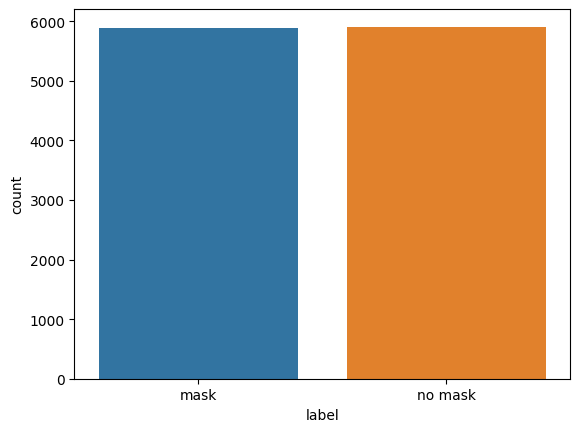

In [6]:
sns.countplot(x=dataset["label"])

### splitting the data

In [7]:
X_train = dataset.iloc[0:10000, ]
X_val = dataset.iloc[10001:11001, ]
X_test = dataset.iloc[11002:, ]

### Creating the dataset

I have used ImageDataGenerator and flow_from_dataframe from tensorflow.keras.preprocessing.image to build the datasets from pandas dataframes

In [8]:
train_ds = ImageDataGenerator(rescale = 1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                              shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

train_ds = train_ds.flow_from_dataframe(dataframe=X_train, x_col="images", y_col="label", target_size=(155, 155),
                                        batch_size = 32, class_mode = "binary")

val_ds = ImageDataGenerator(rescale = 1./255)
val_ds = val_ds.flow_from_dataframe(dataframe=X_val, x_col="images", y_col="label", target_size=(155, 155),
                                    batch_size = 32, class_mode = "binary")

test_ds = ImageDataGenerator(rescale = 1./255)
test_ds = test_ds.flow_from_dataframe(dataframe=X_test, x_col = "images", y_col = "label", target_size = (155, 155),
                                          class_mode = "binary", batch_size = 32)

Found 10000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 790 validated image filenames belonging to 2 classes.


### Definig and building the model

The model takes images of size 155x155 as input.

In [9]:
def model_fn(input_shape = (155,155,3)):
    x_input = Input(input_shape)
    x = x_input
    x = Conv2D(64, kernel_size = (3,3), strides = (1,1), padding = "same")(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2,2))(x)
    x = Conv2D(128, kernel_size = (3,3), strides = (1,1), padding = "same")(x)
    x = Activation("relu")(x)
    x = MaxPool2D((3,3))(x)
    x = Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = "valid")(x)
    x = Activation('relu')(x)
    x = Conv2D(512, kernel_size = (3,3), strides = (1,1), padding = "same")(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2,2))(x)
    x = Conv2D(512, kernel_size = (3,3), strides = (1,1), padding = "same")(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(8)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(8)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs = x_input, outputs = x, name = 'modelfn')
    return model

In [10]:
model = model_fn(input_shape = (155,155,3))

The loss function used is the BinaryCrossentropy.
Adam optimizing algorithm is used with a learning rate of 1*e-4

In [11]:
lossfn = BinaryCrossentropy()
optimizerfn = Adam(0.0001)

In [12]:
model.compile(optimizer = optimizerfn, loss = lossfn, metrics = ["accuracy"])

In [13]:
model.summary()

Model: "modelfn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 155, 155, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 155, 155, 64)      1792      
                                                                 
 activation (Activation)     (None, 155, 155, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 77, 77, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 128)       73856     
                                                                 
 activation_1 (Activation)   (None, 77, 77, 128)       0         
                                                           

### Training the model

In [14]:
history = model.fit(train_ds, epochs=50,validation_data=val_ds)

Epoch 1/50
313/313 [==============================] - 83s 253ms/step - loss: 0.5791 - accuracy: 0.7733 - val_loss: 0.4901 - val_accuracy: 0.8670
Epoch 2/50
313/313 [==============================] - 36s 114ms/step - loss: 0.5203 - accuracy: 0.8423 - val_loss: 0.4294 - val_accuracy: 0.9050
Epoch 3/50
313/313 [==============================] - 36s 114ms/step - loss: 0.4823 - accuracy: 0.8625 - val_loss: 0.3894 - val_accuracy: 0.9330
Epoch 4/50
313/313 [==============================] - 36s 114ms/step - loss: 0.4492 - accuracy: 0.8777 - val_loss: 0.3892 - val_accuracy: 0.9190
Epoch 5/50
313/313 [==============================] - 36s 114ms/step - loss: 0.4198 - accuracy: 0.8937 - val_loss: 0.3363 - val_accuracy: 0.9430
Epoch 6/50
313/313 [==============================] - 36s 113ms/step - loss: 0.4076 - accuracy: 0.8939 - val_loss: 0.3118 - val_accuracy: 0.9510
Epoch 7/50
313/313 [==============================] - 36s 114ms/step - loss: 0.3795 - accuracy: 0.9006 - val_loss: 0.2947 - val_ac

### Visualising the loss and accuracy

C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

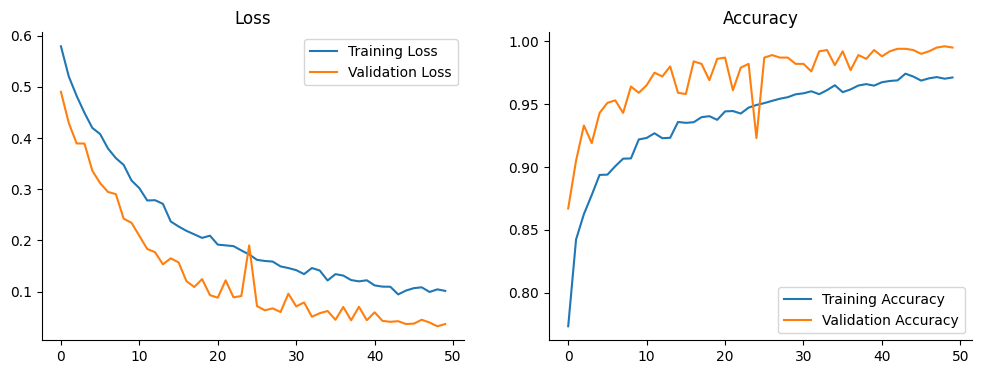

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["accuracy"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["val_accuracy"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

### Testing the model on the Test set

The model achieved an accuracy of 98% in the test set

In [16]:
test_loss, test_acc = model.evaluate(test_ds, steps = 9)
print("Test accuracy = ", round(test_acc, 2))

9/9 [==============================] - 1s 124ms/step - loss: 0.0176 - accuracy: 1.0000
Test accuracy =  1.0


### Saving the model

In [17]:
model_json = model.to_json()

In [18]:
with open('model_json.json','w') as json_file:
    json_file.write(model_json)

In [19]:
model.save('face_mask_detection.h5')